In [1]:
pip install gtfparse

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install panda

Note: you may need to restart the kernel to use updated packages.


In [167]:
#important librairies
import gtfparse
from gtfparse import read_gtf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [168]:
#Important functions

def standardize(x):
    """
    Standardize the dataset by substracting the column's values mean to each value of the column and dividing it by 
    the standart deviation of the values of the columns.
    
    Args:
        x : shape = (N,D) : input matrix.
    Returns:
        x : standardized version of the input matrix.
        mean_x : vector of columns means shape = (D,1)
        std_x : vector of the columns standart deviations shape = (D,1)
    """
    mean_x = np.mean(x, axis=0)
    x = x - mean_x
    std_x = np.std(x, axis=0)
    x = x / std_x
    return x, mean_x, std_x    

def logistic_regression(y, tx, initial_w, max_iters, gamma):
    """Logistic regression
    Arguments:
        y: numpy array of shape=(N, ) , it is the vector of outputs
        tx: numpy array of shape=(N,k) it is the vector of inputs.
        initial_w: numpy array of shape=(k, ). starting points from which we begin the descend
        max_iters: number of iteration.
        gamma: a scalar denoting the stepsize
    Returns:
        w : the vector of weight that we obtain at the end of the descend
       loss(w) : the cost at point w.
    """
    epsilon = 1e-5    
    w = initial_w
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    pred = sigmoid(np.dot(tx, w))

    for i in range(max_iters):
        grad = np.dot(tx.transpose(), pred - y) / y.shape[0]
        w -= gamma * grad
        pred = sigmoid(np.dot(tx, w))

    loss_n = y * np.log(pred + epsilon) + (1 - y) * np.log(1 - pred + epsilon)
    loss = -np.sum(loss_n) / y.shape[0]
    return w, loss


def model_generator(dataset,gama):
    """
    Model that generate the log regression model from datas.
    Args :
        dataset : dataframe containing the input matrix and the output vector.
        gama : size step for log regression.
    Returns:
        loss_model : the lost at the last step of log regression
        w_model : the weights of the log regression model.
    """
    data_for_model = dataset.iloc[0:,2:10]
    data_for_model.head()
    data_for_model = standardize(data_for_model)[0]
    output = dataset.iloc[0:,10]
    output = output.to_numpy()
    bolean_selector = [output != "ambiguous"]
    output = output[bolean_selector[0]]
    #print(len(bolean_selector[0]))
    #print(sum(bolean_selector[0].astype(int)))
    bolean_selector_for_dataframe = pd.Series(bolean_selector[0])
    data_for_model = data_for_model[bolean_selector_for_dataframe.values]
    X = data_for_model.astype(float)
    X = X.to_numpy()
    y = output.astype(float)
    w_model,loss_model =  logistic_regression(y,X,np.ones(8),100,gama)
    return loss_model,w_model

In [169]:
# Dataset
lire1 = pd.read_csv("data_median.csv")
lire2 = pd.read_csv("data_without_one_estimate_for_cell.csv")

Text(0.5, 1.0, 'loss vs gamma for data_median.csv dataset')

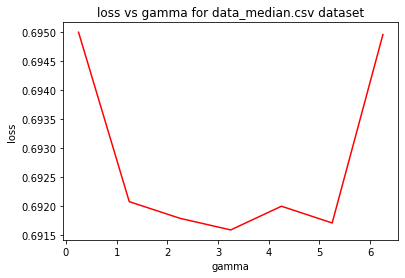

In [170]:
#Test of data_median.csv dataset.
gamma = np.arange(0.25,7.25,1)
loss = []
for value in gamma:
    loss.append(model_generator(lire1,value)[0])
    
plt.plot(gamma,loss,color = 'red')
plt.xlabel('gamma')
plt.ylabel('loss')
plt.title('loss vs gamma for data_median.csv dataset')

Text(0.5, 1.0, 'loss vs gamma for data_median.csv dataset')

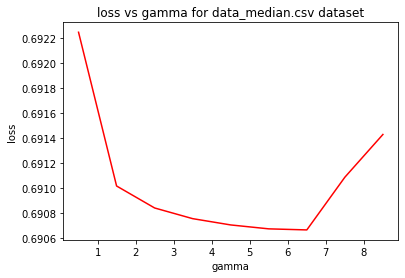

In [171]:
#Test of data_without_one_estimate dataset.
gamma = np.arange(0.5,9.5,1)
loss = []
for value in gamma:
    loss.append(model_generator(lire2,value)[0])
    
plt.plot(gamma,loss,color = 'red')
plt.xlabel('gamma')
plt.ylabel('loss')
plt.title('loss vs gamma for data_median.csv dataset')

In [172]:
w_model = model_generator(lire2,6.5)[1]

In [173]:
print(w_model)

[-0.45005283  0.50981011 -0.06023784 -0.1888034   0.13825146 -0.109952
  0.0202567   0.03641629]


In [174]:
# Classification of genes according to the relation with centrioles assembly/dissasembly
list_of_genes_important_for_centriol_assembly = []
list_of_genes_important_for_centriol_dissassembly = []
non_classified = []
j = 0
while(j < 854322):
    gene_name = lire2.iloc[j,0]
    a = j
    while(lire2.iloc[j,0] == gene_name):
        j += 1
        if (j > 854322):
            break
    b = j-1
    reference =lire2.iloc[a:b,10].to_numpy()
    intput = lire2.iloc[a:b,2:10].to_numpy()
    output = sigmoid(intput.dot(w_model))
    #plt.bar(x= lire.iloc[a:b,1],height = output)
    #plt.title(gene_name)
    #plt.xlabel('cell types')
    #plt.ylabel('probability to have Y = 1')
    #plt.show()
    output[output >= 0.5] = 1
    output[output < 0.5] = 0
    centriol_assembly_score = 0
    centriol_dessasembly_score = 0
    for i in range(0,len(output)):
        if((intput[i,7]-intput[i,0] < 0) and (output[i] == 0)):
            centriol_assembly_score += 1
        elif((intput[i,7]-intput[i,0] > 0) and (output[i] == 0)):
            centriol_dessasembly_score += 1
        elif((intput[i,7]-intput[i,0] > 0) and (output[i] == 1)):
                centriol_assembly_score += 1
        elif((intput[i,7]-intput[i,0] < 0) and (output[i] == 1)):
                centriol_dessasembly_score += 1
    if(centriol_assembly_score > centriol_dessasembly_score):
        list_of_genes_important_for_centriol_assembly.append(gene_name)
    elif(centriol_assembly_score < centriol_dessasembly_score):
        list_of_genes_important_for_centriol_dissassembly.append(gene_name)
    else:
        non_classified.append(gene_name)
          

In [175]:
output1 = pd.DataFrame(data =np.array(list_of_genes_important_for_centriol_assembly), columns = ['genes important for centriol assembly'] )
output2 = pd.DataFrame(data =np.array(list_of_genes_important_for_centriol_dissassembly), columns = ['genes important for centriol dessassembly'] )
output3 = pd.DataFrame(data =np.array(non_classified), columns = ['genes not relevant for the state of centrioles'] )

In [176]:
result1 = open('genes_relevant_for_centriol_assembly.txt','w')
result2 = open('gene_relevant_for_centriol_dissasembly.txt','w')
result3 = open('genes_not_relevant_for_centrioles.txt','w')
result1.close()
result2.close()
result3.close()
output1.to_csv('final_genes_relevant_for_centriol_assembly.txt', header=None, index=None, sep=' ', mode='a')
output2.to_csv('final_gene_relevant_for_centriol_dissasembly.txt', header=None, index=None, sep=' ', mode='a')
output3.to_csv('final_genes_not_relevant_for_centrioles.txt', header=None, index=None, sep=' ', mode='a')
